In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
# import gradient 
import torch

from nb_functions import nearest_neighbors_with_occlusion_kdtree_smart, distance_cutoff, cutoff_and_knn, knn

def rlen(x):
    return range(len(x))

In [ ]:
class Simulation:
    def __init__(self, n_cells, n_steps = 1000, start_positions=None):

        if start_positions is not None:
            sp = torch.tensor(start_positions, requires_grad=True)
            self.cell_rs = sp
            self.n_cells = int(np.sqrt(len(start_positions)))

            self.cell_qs = np.array([[0.0,1.0] for _ in range(n_cells**2)])
            self.cell_qs = torch.tensor(self.cell_qs, requires_grad=True)

        else:
            self.n_cells = n_cells
            self.cell_qs = np.array([[0.0,1.0] for _ in range(n_cells**2)])
            self.cell_rs = np.random.rand(n_cells**2, 2)*10 - 5

            self.cell_rs = torch.tensor(self.cell_rs, requires_grad=True)
            self.cell_qs = torch.tensor(self.cell_qs, requires_grad=True)

        self.dt = 0.1
        
        self.nbs = self.voronoi_neighbors(self.cell_rs.detach().numpy())

        self.elongated_cells = torch.tensor([False for _ in range(n_cells**2)])

        self.time : float = 0.0

        # self.nb_function = lambda points: distance_cutoff(points, 3)
        self.nb_function = lambda points: cutoff_and_knn(points, cutoff = 3, k = 7)

        middle = (self.cell_rs*self.cell_rs).sum(axis = 1) < 30**2
        print(middle.shape)

        self.elongated_cells = middle

        self.n_steps = n_steps

        self.all_poss = torch.empty((n_steps, n_cells**2, 2))

    def S(self, ri, rj):
        return 1

    def V(self, ri, rj, qi, qj, elongated=False):
        dij = rj - ri
        
        # rij = np.linalg.norm(dij)
        # torch len  
        rij = torch.norm(dij) + 1e-6

        if elongated:
            dot = torch.dot(dij/rij, qi)
            rij_t = rij - (dot-0.5)
        else:
            rij_t = rij

        # rij_t = torch.max(rij_t, torch.tensor(1e-3))
        
        return torch.exp(-rij_t) - self.S(ri, rj)*torch.exp(-rij_t/5)


    def voronoi_neighbors(self, points):
        vor = Voronoi(points) 
        neighbors = {i: set() for i in range(len(points))}
        for i, j in vor.ridge_points:
            if i == -1 or j == -1:
                continue
            if i == j:
                continue
            neighbors[i].add(j)
            neighbors[j].add(i)
        return neighbors


    def step(self, should_get_new_nbs):
        if should_get_new_nbs:
            self.nbs = list(self.nb_function(self.cell_rs.detach().numpy()))


        for i in range(self.n_cells**2):
            nb = torch.tensor(list(self.nbs[i]), dtype=torch.int32)


            # get V for all neighbors
            V = torch.tensor(0.0)
            for j in nb:
                V += self.V(self.cell_rs[i], self.cell_rs[j], self.cell_qs[i], self.cell_qs[j], self.elongated_cells[j] or self.elongated_cells[i])

            # get gradient of V
            V.backward()

            # update r
            with torch.no_grad():
                self.cell_rs -= self.cell_rs.grad*self.dt
                # add gaussian noise
                self.cell_rs += (1e-3)*torch.randn_like(self.cell_rs)

            # zero grad
            self.cell_rs.grad.zero_()


    def show(self):
        rs = self.cell_rs.detach().numpy()
        qs = self.cell_qs.detach().numpy()
        ec = self.elongated_cells.numpy()

        plt.scatter(rs[:,0], rs[:,1], c = ec)
        plt.title(f"Time: {self.time:.3} | Step: {int(self.time/self.dt)}")
        plt.axis('square')
        



        for i in rlen(ec):
            if ec[i]:

                plt.quiver(rs[i,0], rs[i,1], qs[i,0], qs[i,1], color='red')
        plt.show()

    def run(self):
        self.show()
        for i in range(self.n_steps):
            newnbs = i%50 == 0

            self.step(should_get_new_nbs = newnbs)

            self.time += self.dt

            if i % 100 == 0:
                self.show()

            self.all_poss[i] = self.cell_rs.detach()




C:\Users\jakob\AppData\Local\Temp\ipykernel_25168\4229065806.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sp = torch.tensor(start_positions, requires_grad=True)


torch.Size([100])


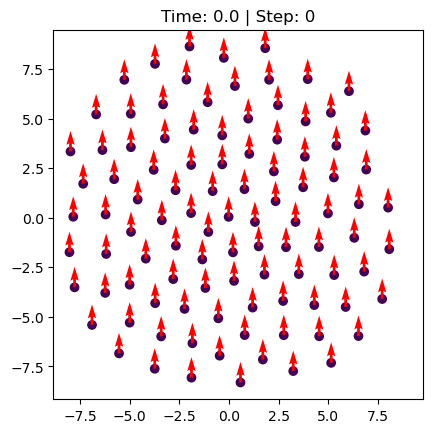

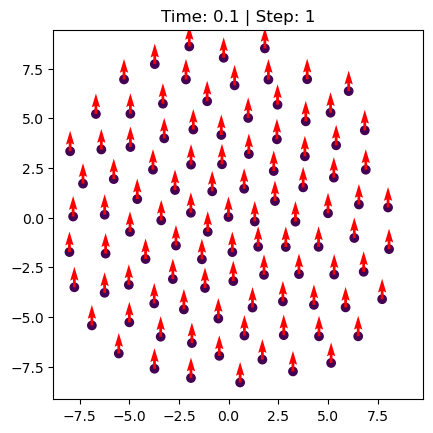

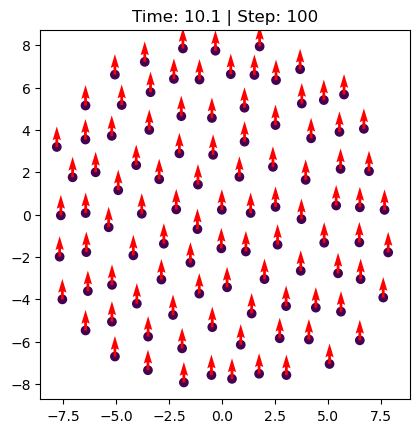

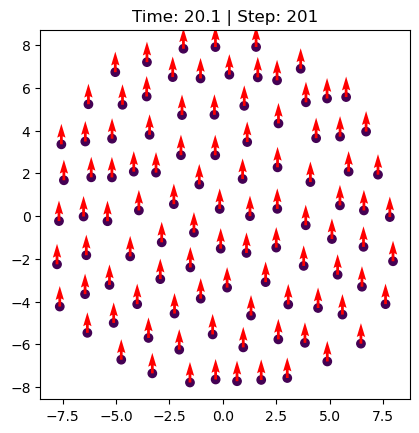

In [ ]:
sim = Simulation(10, 500, eq_poss)
sim.run()

In [128]:
all_poss = sim.all_poss.detach().numpy()
elongated_cells = sim.elongated_cells.numpy()
qs = sim.cell_qs.detach().numpy()

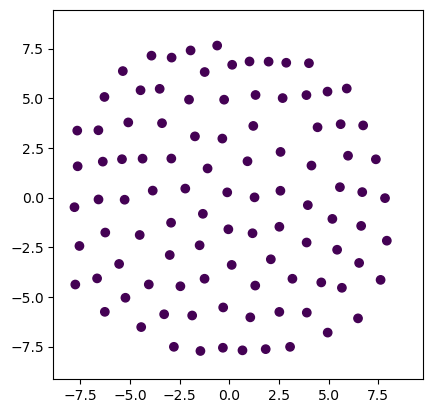

In [124]:
# make a ipython animation
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots()
# ax.set_xlim(-10, 10)
# ax.set_ylim(-10, 10)
scatplot = ax.scatter(all_poss[0,:,0], all_poss[0,:,1], c = elongated_cells)

plt.axis('square')


def update_plot(i, all_poss, scatplot):
    scatplot.set_offsets(all_poss[i])

    # fig.canvas.update()
    fig.canvas.flush_events()

    return scatplot,

ani = animation.FuncAnimation(fig, update_plot, frames=rlen(all_poss)[::2], fargs=(all_poss, scatplot), interval=50, blit=True)

HTML(ani.to_jshtml())



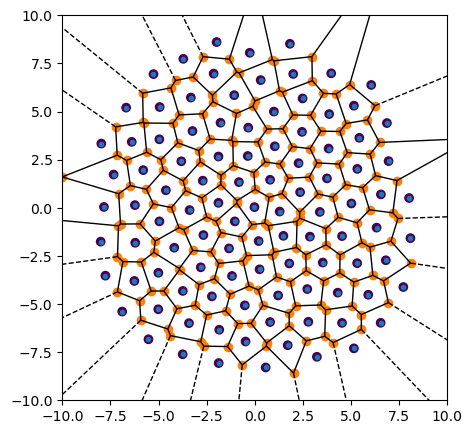

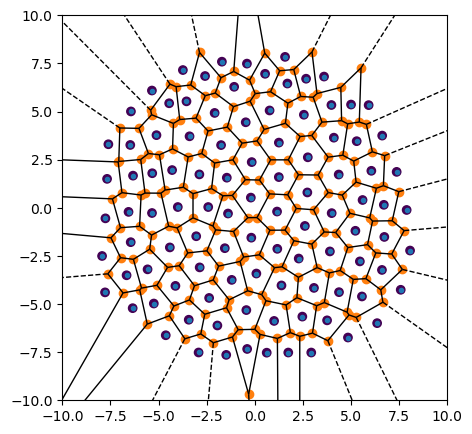

In [129]:
for frame_id in [0,-1]:
    # draw as voronoi diagram

    from scipy.spatial import Voronoi, voronoi_plot_2d

    vor = Voronoi(all_poss[frame_id])

    fig, ax = plt.subplots(figsize=(5,5))
    voronoi_plot_2d(vor, ax)

    ax.scatter(all_poss[frame_id,:,0], all_poss[frame_id,:,1], c = elongated_cells)



    plt.axis('square')
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)

    plt.show()